This notebook calculate the land cover information.

In [2]:
import glob
import os
from os.path import join
from natsort import natsorted
import rasterio
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm

import time
import copy

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors


colors_list = ['yellow', 'pink', 'teal', 'gray', 'red', 'white', 'aqua', 'orange', 'darkblue']
cmap = mpl.colors.ListedColormap(colors_list)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 256]
norm = colors.BoundaryNorm(bounds, cmap.N)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.14.0.dev20221103+cu117
Torchvision Version:  0.15.0.dev20221103+cu117


In [3]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [4]:
model_path = '/mnt/ceph/boyuz/Builiding_Landscaping/land_conver_segmentation/partial_label/code/cnn_model_5_epoch_30.pt'

raster_list = [
    '/mnt/ceph/boyuz/BU_Classifier/Bafodia_Google.tif'
    ]

tile_size = 64
step = 5 
site_id = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
model = torch.load(model_path)
model.eval()
model.to(device);


In [7]:
test_img = imageio.imread(raster_list[0])[:,:,:3]
# site = raster_list[site_id].split(os.sep)[-1][:-4]
site = 'Bafodia_Google'
print(f'Processing site: {site}')

Processing site: Bafodia_Google


In [8]:
x_range = range(0, test_img.shape[0]-tile_size, step)
y_range = range(0, test_img.shape[1]-tile_size, step)
print(len(x_range), len(y_range))

3916 5012


In [9]:
results_mat = []

for x in tqdm(x_range):
    # get tiles for each row
    tiles_row = []
    for y in y_range:
        tiles_row.append(test_img[x:x+tile_size, y:y+tile_size, :])
    # too big, split to 3 parts to fit the GPU ram
    tile_list_row = split(tiles_row, 3)

    result_row = []
    for tile_list in tile_list_row:
        tile_list = np.moveaxis(np.array(tile_list), -1, 1)
        input = torch.tensor(tile_list, dtype=torch.float)
        output = model(input.to(device))
        _, preds = torch.max(output, 1)
        result_row = result_row + list(preds.detach().cpu().numpy())
    
    results_mat.append(result_row)


100%|██████████| 3916/3916 [32:25<00:00,  2.01it/s]


In [11]:
result_array.shape

(3916, 5012)

In [10]:
result_array = np.array([np.array(x) for x in results_mat])
np.save(str(tile_size) + '_' + str(step) + '_' + site, result_array)

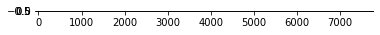

In [14]:
plt.imshow(result_array, cmap = cmap, norm = norm, interpolation = 'none')

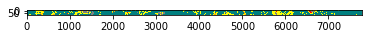

In [3]:
part_result = np.load('64_5_Bantou.npy')
plt.imshow(part_result, cmap = cmap, norm = norm, interpolation = 'none')